# Generate the plots for Fig. 1

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from definitions import ROOT_DIR
from helpers import get_data_from_tb_log, butter_lowpass_filter, create_directory_if_not_exists

MyoSuite:> Registering Myo Envs


In [2]:
EXPERIMENTS_DIR = os.path.join(ROOT_DIR, "trained_models", "curriculum_steps_complete_baoding_winner")
attributes = ("rollout/ep_rew_mean", "eval/score")
tb_dir_name = "RecurrentPPO_1"

## Load and plot the learning curves

In [3]:
curriculum_steps = sorted(os.listdir(EXPERIMENTS_DIR))
curriculum_data_dict = {a: [] for a in attributes}  # {attribute: [{step: val, time: val, value: val}]}

for experiment in curriculum_steps:
    experiment_dir = os.path.join(EXPERIMENTS_DIR, experiment)
    print(f"'{experiment_dir}'")
    tb_dir_path = os.path.join(experiment_dir, tb_dir_name)

    if os.path.isdir(tb_dir_path):
        folder_content = os.listdir(tb_dir_path)
        assert len(folder_content) == 1
        tb_file_name = folder_content[0]
        tb_file_path = os.path.join(tb_dir_path, tb_file_name)
        time_dict = get_data_from_tb_log(tb_file_path, attributes, x="wall_time")
        step_dict = get_data_from_tb_log(tb_file_path, attributes, x="step")
        for attr, values in step_dict.items():
            if values is None:
                curriculum_data_dict[attr].append({"step": np.array([]), "time": np.array([]), "value": np.array([])})
            else:
                time_vec = time_dict[attr][0]  # The x of the time data
                time_vec = (time_vec - time_vec[0]) / 3.6e3  # Train time in hours (relative)
                curriculum_data_dict[attr].append({"step": values[0], "time": time_vec, "value": values[1]})

'/home/nisheet/projects/MyoChallengeAnalysis/trained_models/curriculum_steps_complete_baoding_winner/01_rsi_static'
'/home/nisheet/projects/MyoChallengeAnalysis/trained_models/curriculum_steps_complete_baoding_winner/02_rsi_period_30'
'/home/nisheet/projects/MyoChallengeAnalysis/trained_models/curriculum_steps_complete_baoding_winner/03_rsi_period_25'
'/home/nisheet/projects/MyoChallengeAnalysis/trained_models/curriculum_steps_complete_baoding_winner/04_rsi_prob_0.9_period_20'
'/home/nisheet/projects/MyoChallengeAnalysis/trained_models/curriculum_steps_complete_baoding_winner/05_rsi_prob_0.9_period_15'
'/home/nisheet/projects/MyoChallengeAnalysis/trained_models/curriculum_steps_complete_baoding_winner/06_period_10'
'/home/nisheet/projects/MyoChallengeAnalysis/trained_models/curriculum_steps_complete_baoding_winner/07_period_9'
'/home/nisheet/projects/MyoChallengeAnalysis/trained_models/curriculum_steps_complete_baoding_winner/08_period_8'
'/home/nisheet/projects/MyoChallengeAnalysis/tr

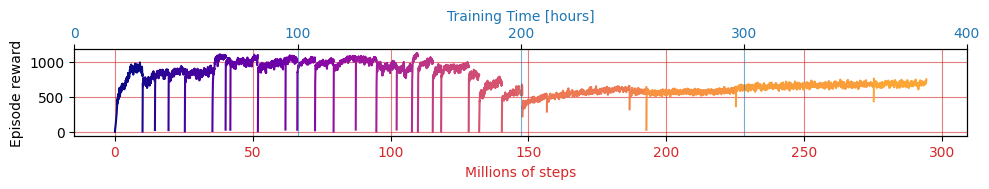

In [5]:
attr = "rollout/ep_rew_mean"
data = curriculum_data_dict[attr]
line_colors = plt.cm.plasma(np.linspace(0, 0.8, len(data)))
fig, ax1 = plt.subplots(figsize=(10, 2))
last_step = 0
last_time = 0
time_vec_list = []
step_vec_list = []
for idx, c_step in enumerate(data):
    x = (c_step["step"] * 1e-6 + last_step)
    y = c_step["value"]
    if len(c_step["step"]) > 0:
        if len(y) > 51:
            fs = len(x) / (x[-1] - x[0])
            y = butter_lowpass_filter(y, cutoff=5, fs=fs, order=1)
        ax1.plot(x, y, color=line_colors[idx])
        last_step = x[-1]
        time = c_step["time"] + last_time
        last_time = time[-1]
        step_vec_list.append(x)
        time_vec_list.append(time)
        
step = np.concatenate(step_vec_list) 
time = np.concatenate(time_vec_list).astype(int)
color = 'tab:red'
ax1.set_xlabel('Millions of steps', color=color)
ax1.set_ylabel('Episode reward')
ax1.tick_params(axis='y')
ax1.grid(True, color=color, alpha=0.6)
ax1.tick_params(axis='x', labelcolor=color)


ax2 = ax1.twiny()  # instantiate a second axes that shares the same y-axis
color = 'tab:blue'
ax2.set_xlabel('Training Time [hours]', color=color)
# ax2.plot(time, value, color=color, marker='o', label='Loss')
ax2.tick_params(axis='x', labelcolor=color)

# Add iteration step as x-ticks on the top axis
ax2.set_xticks(np.arange(time[0], time[-1], 100))
ax2.set_xticklabels(np.arange(time[0], time[-1], 100))

# Customize plot
ax2.grid(True, color=color, alpha=0.6)
fig.tight_layout()  # ensure that all the labels fit comfortably
attr_print = attr.replace("/", "_")

out_path = os.path.join(ROOT_DIR, "data", "figures", "fig_1")
os.makedirs(out_path, exist_ok=True)

out_name = f"learning_curve_curriculum_{attr_print}"
fig.savefig(os.path.join(out_path, out_name + ".png"), format="png", dpi=800, bbox_inches="tight")

plt.show()
